In [1]:
import math
import numpy as np
import cvxopt
from cvxopt import matrix
from cvxopt.solvers import qp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
mu = np.array([0.05, 0.06, 0.08, 0.06])
vol = np.array([0.15, 0.2, 0.25, 0.3])
rho = np.array([[1, 0.1, 0.4, 0.5],
              [0.1, 1, 0.7, 0.4],
              [0.4, 0.7, 1, 0.8],
              [0.5, 0.4, 0.8, 1]])

1. Represent the efficient frontier

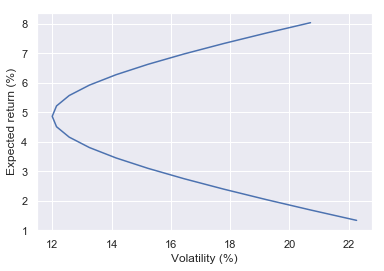

In [3]:
sigma = vol * rho * vol.reshape((vol.shape[0],1))
vec_one = np.ones(vol.shape)
vec_zero = np.zeros(vol.shape)

cvxopt.solvers.options['show_progress'] = False

P = matrix(sigma)
q = matrix(mu)
A = matrix(vec_one).trans()
b = matrix(1.0)
G = matrix()

gamma = np.arange(-1,1,0.1)
s_result, exp_returns = np.zeros(gamma.size), np.zeros(gamma.size)
for i in range(gamma.size):
    x = np.array(qp(P=P,q=-matrix(gamma[i]*q),A=A,b=b)['x'])
    x = x.reshape((x.shape[0],))
    exp_returns[i] = np.dot(x,mu)
    s_result[i] = math.sqrt(np.dot(x,np.dot(sigma,x)))

ax = plt.axes()
p = plt.plot(s_result*100,exp_returns*100)
a = ax.set(xlabel='Volatility (%)',ylabel='Expected return (%)')

2. Calculate the minimum variance portfolio. What are its expected return and its volatility ?

In [4]:
x = np.array(qp(P=P,q=matrix(0*q),A=A,b=b)['x'])
x = x.reshape((x.shape[0],))
print x
print np.dot(x,mu)
print math.sqrt(np.dot(x,np.dot(sigma,x)))

[ 0.72742452  0.49464311 -0.20453597 -0.01753165]
0.04863503548072911
0.119951987055


3. Calculate the optimal portfolio which has an ex-ante volatility of $\sigma^\star=20\%$.

In [79]:
target_vol = 0.2
precision = 0.000001

gamma_plus, gamma_minus = 1, 0
x_plus, x_minus = np.array(qp(P=P,q=matrix(gamma_plus*q),A=A,b=b)['x']), np.array(qp(P=P,q=matrix(gamma_minus*q),A=A,b=b)['x'])
x_plus, x_minus = x_plus.reshape((x_plus.shape[0],)), x_minus.reshape((x_minus.shape[0],))
s_plus, s_minus = math.sqrt(np.dot(x_plus, np.dot(sigma,x_plus))), math.sqrt(np.dot(x_minus, np.dot(sigma,x_minus)))
s_mean = (s_plus+s_minus)/2.0
while math.fabs(s_mean-target_vol)>precision:
    if s_mean>target_vol:
        gamma_plus = (gamma_plus+gamma_minus)/2.0
        x_plus = np.array(qp(P=P,q=-matrix(gamma_plus*q),A=A,b=b)['x'])
        x_plus = x_plus.reshape((x_plus.shape[0],))
        s_plus = math.sqrt(np.dot(x_plus, np.dot(sigma,x_plus)))
    else:
        gamma_minus = (gamma_plus+gamma_minus)/2.0
        x_minus = np.array(qp(P=P,q=-matrix(gamma_minus*q),A=A,b=b)['x'])
        x_minus = x_minus.reshape((x_minus.shape[0],))
        s_minus = math.sqrt(np.dot(x_minus, np.dot(sigma,x_minus)))
    s_mean = (s_plus+s_minus)/2.0

print x_minus
print np.dot(x_minus,mu)

[ 0.54585319 -0.10716778  1.20501426 -0.64369967]
0.07864175333936271


4. We note $x^{(1)}$ the minimum variance portfolio and $x^{(2)}$ the optimal portfolio with $\sigma^\star=20\%$. We consider the set of portfolios $x^{(\alpha)}$ defined by the relationship: $x^{(\alpha)}=(1-\alpha)x^{(1)}+\alpha x^{(2)}$.

In the previous efficient frontier, place the portfolios $x^{(\alpha)}$.

In [6]:
x_1 = x
x_2 = x_minus

alpha = np.arange(-0.5,1,0.1)
s_alpha, r_alpha = np.zeros(alpha.size), np.zeros(alpha.size)
for i in range(alpha.size):
    x_alpha = (1-alpha[i])*x_1 + alpha[i]*x_2
    r_alpha[i] = np.dot(x_alpha,mu)
    s_alpha[i] = math.sqrt(np.dot(x_alpha, np.dot(x_alpha,sigma)))

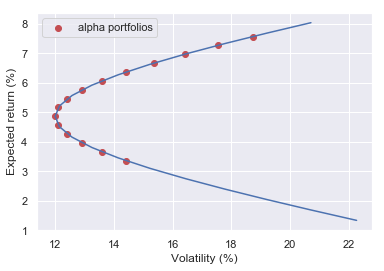

In [7]:
ax = plt.axes()
p = plt.plot(s_result*100,exp_returns*100)
g = plt.scatter(s_alpha*100,r_alpha*100,color='r',label='alpha portfolios')
a = ax.set(xlabel='Volatility (%)',ylabel='Expected return (%)')
plt.legend();

5. Find the MV portfolio and the ex-ante $\sigma^\star=20\%$ portfolio with the constraint $0\leq x_i\leq1$.

In [34]:
h = matrix(np.concatenate((vec_zero,vec_one)))
G = matrix(np.concatenate((-np.eye(4),np.eye(4))))

x = np.array(qp(P=P,q=matrix(0*q),G=G,h=h,A=A,b=b)['x'])
x = x.reshape((x.shape[0],))
print x
print np.dot(x,mu)
print math.sqrt(np.dot(x,np.dot(sigma,x)))

[6.54867054e-01 3.45132580e-01 1.67988301e-07 1.98276151e-07]
0.053451332822966
0.125578327903


In [120]:
target_vol = 0.2
precision = 0.000001

gamma_plus, gamma_minus = 2.0 ,0
x_plus, x_minus = np.array(qp(P=P,q=-matrix(gamma_plus*q),G=G,h=h,A=A,b=b)['x']), np.array(qp(P=P,q=-matrix(gamma_minus*q),G=G,h=h,A=A,b=b)['x'])
x_plus, x_minus = x_plus.reshape((x_plus.shape[0],)), x_minus.reshape((x_minus.shape[0],))
s_plus, s_minus = math.sqrt(np.dot(x_plus, np.dot(sigma,x_plus))), math.sqrt(np.dot(x_minus, np.dot(sigma,x_minus)))
s_mean = (s_plus+s_minus)/2.0
while math.fabs(s_mean-target_vol)>precision:
    if s_mean>target_vol:
        gamma_plus = (gamma_plus+gamma_minus)/2.0
        x_plus = np.array(qp(P=P,q=-matrix(gamma_plus*q),G=G,h=h,A=A,b=b)['x'])
        x_plus = x_plus.reshape((x_plus.shape[0],))
        s_plus = math.sqrt(np.dot(x_plus, np.dot(sigma,x_plus)))
    else:
        gamma_minus = (gamma_plus+gamma_minus)/2.0
        x_minus = np.array(qp(P=P,q=-matrix(gamma_minus*q),G=G,h=h,A=A,b=b)['x'])
        x_minus = x_minus.reshape((x_minus.shape[0],))
        s_minus = math.sqrt(np.dot(x_minus, np.dot(sigma,x_minus)))
    s_mean = (s_plus+s_minus)/2.0


print x_minus
print np.dot(x_minus,mu)
print math.sqrt(np.dot(x_minus,np.dot(x_minus,sigma)))

[2.48826874e-01 4.96442344e-02 7.01528888e-01 4.04328088e-09]
0.07154230901928742
0.199998410255


In [117]:
x = np.array(qp(P=P,q=-matrix(2.0*q),G=G,h=h,A=A,b=b)['x'])
x = x.reshape((x.shape[0],))
print x
print np.dot(x,mu)
print math.sqrt(np.dot(x,np.dot(sigma,x)))

[2.07431417e-07 6.72231865e-08 9.99999724e-01 1.40796441e-09]
0.07999999240443446
0.249999953179
